# ===========================================================
# Full pipeline for the influence matrix estimation problem on the supervised dataset from the Jeopardy-like logs for comparison on different models
# ===========================================================

Goals:
1. Split the data into test and train, and validation for multiple runs
2. Formulate all different models of convex optimization, neural networks, and tower models.
3. Give the same splits to all models, tune the hyperparameters with validation set, and report train and test erros as a pickle, a table, and a figure

#### Started on: 30 Dec 2019
#### Last update: 07 Jan 2020

# Imports

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals

import imp
import sys
import scipy as sp
import cvxpy as cp
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Concatenate, Reshape, Embedding, Dot
from tensorflow.keras.models import Model
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
import mytools
from estimation_lib import *
from mytools import Timer
from mytools import Tee

/home/omid/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/omid/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Parameters

In [2]:
DATA_FILE_PATH = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
# DATA_FILE_PATH = '/home/omid/Datasets/Jeopardy/supervised_data_roberta.pk'
TEST_FRACTION = 0.2
RUNS = 10

LAMBDAS = [0, 0.1, 1, 10, 100, 1000]
WITH_REPLICATION = True
ERROR_TYPE_STRS = ['mse']  # 'normalized_frob_norm', 'neg_corr', 'cosine_dist']
TUNE_HYPERPARAMETERS_BY_VALIDATION = True
SELECTED_MODEL_FUNCS = ['average', 'uniform', 'random', last_model_func, sbt_model_func, mei_inspired_model_func, convex_optimization_model_func, concatinated_deep_neural_network_model_func]
FEATURE_NAMES_SET = [['previous_influence_matrix', 'individual_performance'], ['previous_influence_matrix', 'individual_performance', 'reply_duration'], ['previous_influence_matrix', 'individual_performance', 'reply_duration', 'sentiment'], ['previous_influence_matrix', 'individual_performance', 'reply_duration', 'sentiment', 'average_of_previous_influence_matrices']]
# FEATURE_NAMES_SET = [['individual_performance'], ['first_influence_matrix'], ['reply_duration'], ['sentiment'], ['average_of_previous_influence_matrices'], ['first_influence_matrix', 'individual_performance'], ['first_influence_matrix', 'individual_performance', 'reply_duration'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance', 'average_of_previous_influence_matrices']]  # ['content_embedding_matrix'],
ESTIMATION_NAME = 'influence_matrix'  # 'most_influentials'

TO_WRITE_LOGS_ON_FILE = True

# Helper functions 

In [3]:
def reload():
    imp.reload(utils)
    imp.reload(mytools)

In [4]:
def plot_all_result_from_errors_in_runs(errors_in_runs):
    for error_type_str, features_dt in errors_in_runs.items():
        all_feature_set = sorted(features_dt.keys(), reverse=True)
        for feature_set in all_feature_set:
            models_dt = features_dt[feature_set]
            this_error_dt = []
            for model_str, errors in models_dt.items():
                if model_str == 'concatinated_deep_neural_network_model_func':
                    model_str = 'NN'
                elif model_str == 'convex_optimization_model_func':
                    model_str = 'convex'
                e = '{:.4f} $\pm$ {:.4f}'.format(np.mean(errors), np.std(errors))
#                 if model_str == 'random':
#                     continue  # Ignores the random model.
                for err in errors:
                    this_error_dt.append([model_str, err])
            df = pd.DataFrame(this_error_dt, columns=['Model', 'Error'])
            sns.boxplot(x='Model', y='Error', data=df)
            plt.title('{} and {}'.format(error_type_str, feature_set))
            plt.show()
            print('\n')
            
            
def get_errors_in_table(errors_in_runs, ONLY_FOR_THIS_ERROR_TYPE_STR='mse'):
    order_of_models = np.array(
        ['random',
         'uniform',
         'average',
         'sbt_model_func',
         'mei_inspired_model_func',
         'convex_optimization_model_func',
         'concatinated_deep_neural_network_model_func'])
    all_errors_dt = []
    features_dt = errors_in_runs[ONLY_FOR_THIS_ERROR_TYPE_STR]
    all_feature_set = sorted(features_dt.keys(), key=len)   # sorted(features_dt.keys(), reverse=True)
    for feature_set in all_feature_set:
        models_dt = features_dt[feature_set]
        errs = ['' for _ in range(len(order_of_models))]
        for model_str, errors in models_dt.items():
            e = '{:.4f} $\pm$ {:.4f}'.format(np.mean(errors), np.std(errors))
            errs[np.where(order_of_models == model_str)[0][0]] = e
        all_errors_dt.append([feature_set] + errs)
    return pd.DataFrame(all_errors_dt, columns=['Features'] + list(order_of_models))

# Loading the data

In [5]:
data = utils.load_it(DATA_FILE_PATH)
print(len(data['X']))

264


# Main body

## Estimation comparison pipeline

In [6]:
if TO_WRITE_LOGS_ON_FILE:
    f = open('Outputs/output_run_at{}.txt'.format(str(datetime.now())), 'w')
    sys.stdout = Tee(sys.stdout, f)


with Timer():
    train_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    test_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    validation_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for run in range(RUNS):
        print('Run', run + 1, '=>>>')
        X_train, X_test, y_train, y_test = train_test_split(
            np.array(data['X']), np.array(data['y']), test_size=TEST_FRACTION)
        for feature_names in FEATURE_NAMES_SET:
            print('\tFeatures: ', feature_names, '...')
            for selected_model_func in SELECTED_MODEL_FUNCS:
                if isinstance(selected_model_func, str):
                    selected_model_func_str = selected_model_func
                else:
                    selected_model_func_str = selected_model_func.__name__
                print('\t\tModel: ', selected_model_func_str, '...')
                for error_type_str in ERROR_TYPE_STRS:
                    print('\t\t\tError type: ', error_type_str)
                    train_error = 0
                    test_error = 0
                    validation_errors = 0
                    try:
                        train_error, test_error, validation_errors = model_builder(
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test,
                            feature_names=feature_names,
                            estimation_name=ESTIMATION_NAME,
                            error_type_str=error_type_str,
                            tune_hyperparameters_by_validation=TUNE_HYPERPARAMETERS_BY_VALIDATION,
                            with_replication=WITH_REPLICATION,
                            lambdas=LAMBDAS,
                            model_func=selected_model_func,
                            params={'with_constraints': True, 'n_splits': 3, 'n_epochs': 10, 'batch_size': 32, 'mode': 1})
                    except Exception as e:
                        print('An exception was raised:')
                        print(type(e.args))
                        print(e)
                        print('\n')
                        continue
                    key_str = error_type_str + ':' + str(feature_names) + ':' + selected_model_func_str
                    train_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        train_error)
                    test_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        test_error)
                    validation_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        validation_errors)
        utils.save_it(
            obj=train_errors_in_runs,
            file_path='Outputs/train_errors_new{}.pkl'.format(run+1),
            verbose=True)
        utils.save_it(
            obj=test_errors_in_runs,
            file_path='Outputs/test_errors_new{}.pkl'.format(run+1),
            verbose=True)
        utils.save_it(
            obj=validation_errors_in_runs,
            file_path='Outputs/validation_errors_new{}.pkl'.format(run+1),
            verbose=True)
    print('ALL DONE SUCCESSFULLY.')

Run 1 =>>>
	Features:  ['previous_influence_matrix', 'individual_performance'] ...
		Model:  average ...
			Error type:  mse
		Model:  uniform ...
			Error type:  mse
		Model:  random ...
			Error type:  mse
		Model:  last_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Training with the best lambda: 0 on entire training set...
Replicating ...
		Model:  sbt_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Training with the best lambda: 0 on entire training set...
Replicating ...
		Model:  mei_inspired_model_func ...
			Error type:  m

Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 15.1819 - accuracy: 0.093 - ETA: 0s - loss: 14.5331 - accuracy: 0.198 - ETA: 0s - loss: 14.0204 - accuracy: 0.189 - 0s 40us/sample - loss: 13.7702 - accuracy: 0.1795
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 12.6796 - accuracy: 0.281 - ETA: 0s - loss: 12.4136 - accuracy: 0.187 - ETA: 0s - loss: 12.2230 - accuracy: 0.182 - 0s 40us/sample - loss: 12.1334 - accuracy: 0.1741
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 11.7567 - accuracy: 0.031 - ETA: 0s - loss: 11.6651 - accuracy: 0.142 - ETA: 0s - loss: 11.5894 - accuracy: 0.143 - 0s 40us/sample - loss: 11.5523 - accuracy: 0.1435
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 11.3849 - accuracy: 0.125 - ETA: 0s - loss: 11.3530 - accuracy: 0.140 - ETA: 0s - loss: 11.3202 - accuracy: 0.125 - 0s 39us/sample - loss: 11.3062 - accuracy: 0.1202
Epoch 9/10
3360/3360 [==========================

3360/3360 [==============================] - ETA: 0s - loss: 692.8796 - accuracy: 0.15 - ETA: 0s - loss: 600.0427 - accuracy: 0.13 - ETA: 0s - loss: 521.2058 - accuracy: 0.11 - 0s 40us/sample - loss: 480.5753 - accuracy: 0.1167
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 315.5338 - accuracy: 0.12 - ETA: 0s - loss: 267.6643 - accuracy: 0.10 - ETA: 0s - loss: 231.1239 - accuracy: 0.12 - 0s 38us/sample - loss: 218.1302 - accuracy: 0.1232
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 145.5052 - accuracy: 0.09 - ETA: 0s - loss: 127.9500 - accuracy: 0.13 - ETA: 0s - loss: 114.1436 - accuracy: 0.13 - 0s 39us/sample - loss: 108.3887 - accuracy: 0.1369
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 80.3067 - accuracy: 0.062 - ETA: 0s - loss: 75.8995 - accuracy: 0.156 - ETA: 0s - loss: 73.7507 - accuracy: 0.131 - 0s 38us/sample - loss: 72.8290 - accuracy: 0.1310
Input size for the neural network was: 17
Train on 3360

3384/3384 [==============================] - ETA: 0s - loss: 11.2397 - accuracy: 0.093 - ETA: 0s - loss: 11.2341 - accuracy: 0.111 - ETA: 0s - loss: 11.2209 - accuracy: 0.142 - 0s 42us/sample - loss: 11.2116 - accuracy: 0.1507
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 11.1667 - accuracy: 0.250 - ETA: 0s - loss: 11.1755 - accuracy: 0.129 - ETA: 0s - loss: 11.1693 - accuracy: 0.125 - 0s 43us/sample - loss: 11.1661 - accuracy: 0.1212
Input size for the neural network was: 17
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 925.8370 - accuracy: 0.09 - ETA: 1s - loss: 860.0050 - accuracy: 0.0625 - ETA: 0s - loss: 794.3923 - accuracy: 0.06 - ETA: 0s - loss: 723.9212 - accuracy: 0.08 - 1s 234us/sample - loss: 695.5724 - accuracy: 0.0901
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 495.2633 - accuracy: 0.12 - ETA: 0s - loss: 437.9835 - accuracy: 0.17 - ETA: 0s - loss: 390.6715 - accuracy: 0

Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:01 - loss: 928963.5625 - accuracy: 0.031 - ETA: 2s - loss: 867925.6850 - accuracy: 0.0225  - ETA: 0s - loss: 798474.3375 - accuracy: 0.029 - ETA: 0s - loss: 734706.8551 - accuracy: 0.045 - 1s 229us/sample - loss: 693792.3247 - accuracy: 0.0588
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 489708.9062 - accuracy: 0.093 - ETA: 0s - loss: 437031.1667 - accuracy: 0.139 - ETA: 0s - loss: 385235.5633 - accuracy: 0.165 - 0s 42us/sample - loss: 349259.1970 - accuracy: 0.2063
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 231646.6250 - accuracy: 0.343 - ETA: 0s - loss: 199222.3191 - accuracy: 0.224 - ETA: 0s - loss: 171649.9905 - accuracy: 0.173 - 0s 41us/sample - loss: 156402.1095 - accuracy: 0.1637
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 96798.8828 - accuracy: 0.15 - ETA: 0s - loss: 81648.0415 - accuracy: 0.12 - ETA: 0s - loss:

3384/3384 [==============================] - ETA: 0s - loss: 489.6247 - accuracy: 0.25 - ETA: 0s - loss: 436.1707 - accuracy: 0.26 - ETA: 0s - loss: 387.2279 - accuracy: 0.28 - 0s 43us/sample - loss: 353.3391 - accuracy: 0.2896
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 238.3779 - accuracy: 0.34 - ETA: 0s - loss: 206.2255 - accuracy: 0.26 - ETA: 0s - loss: 179.2510 - accuracy: 0.24 - 0s 40us/sample - loss: 166.1329 - accuracy: 0.2210
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 107.2939 - accuracy: 0.15 - ETA: 0s - loss: 91.4191 - accuracy: 0.1421 - ETA: 0s - loss: 79.5492 - accuracy: 0.149 - 0s 40us/sample - loss: 72.9052 - accuracy: 0.1495
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 47.2987 - accuracy: 0.125 - ETA: 0s - loss: 41.2684 - accuracy: 0.153 - ETA: 0s - loss: 36.4540 - accuracy: 0.152 - 0s 40us/sample - loss: 33.9995 - accuracy: 0.1478
Epoch 6/10
3384/3384 [==============================] - 

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 104263.1875 - accuracy: 0.062 - ETA: 0s - loss: 87370.8958 - accuracy: 0.188 - ETA: 0s - loss: 73933.9624 - accuracy: 0.18 - 0s 40us/sample - loss: 67269.7486 - accuracy: 0.1708
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 39387.1328 - accuracy: 0.31 - ETA: 0s - loss: 32533.8673 - accuracy: 0.13 - ETA: 0s - loss: 27337.6274 - accuracy: 0.12 - 0s 40us/sample - loss: 24791.3760 - accuracy: 0.1229
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 14039.3164 - accuracy: 0.03 - ETA: 0s - loss: 11673.1459 - accuracy: 0.12 - ETA: 0s - loss: 9898.7664 - accuracy: 0.1397 - 0s 39us/sample - loss: 9096.7827 - accuracy: 0.1336
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 5571.6733 - accuracy: 0.031 - ETA: 0s - loss: 4702.7355 - accuracy: 0.148 - ETA: 0s - loss: 4044.4566 - accuracy: 0.153 - 0s 39us/sample - loss: 3732.1814 - accuracy: 0.1401
Epoch 8/10

Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 289.0960993859257
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 326.45070747425234
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 686.470455907302
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 4286.470374137839
Training with the best lambda: 0 on entire training set...
Replicating ...
Computing convex loss on 5064 training data samples.
The status of solution was: optimal and the result was: 419.8282464227293
		Model:  concatinated_deep_neural_network_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 33
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================

3360/3360 [==============================] - ETA: 0s - loss: 11.6950 - accuracy: 0.062 - ETA: 0s - loss: 11.6701 - accuracy: 0.124 - ETA: 0s - loss: 11.6703 - accuracy: 0.119 - 0s 38us/sample - loss: 11.6698 - accuracy: 0.1146
Input size for the neural network was: 33
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:12 - loss: 10543.4189 - accuracy: 0.03 - ETA: 2s - loss: 9853.8982 - accuracy: 0.0547   - ETA: 0s - loss: 9122.6769 - accuracy: 0.062 - ETA: 0s - loss: 8393.1202 - accuracy: 0.077 - 1s 266us/sample - loss: 7860.8872 - accuracy: 0.0866
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 5602.1338 - accuracy: 0.156 - ETA: 0s - loss: 4962.4382 - accuracy: 0.115 - ETA: 0s - loss: 4465.6824 - accuracy: 0.121 - 0s 45us/sample - loss: 4013.2044 - accuracy: 0.1241
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 2665.0015 - accuracy: 0.093 - ETA: 0s - loss: 2308.4793 - accuracy: 0.121 - ETA: 0s - loss: 1

3384/3384 [==============================] - ETA: 57s - loss: 11.4681 - accuracy: 0.12 - ETA: 2s - loss: 11.2703 - accuracy: 0.0685 - ETA: 0s - loss: 11.1909 - accuracy: 0.070 - ETA: 0s - loss: 11.1547 - accuracy: 0.085 - ETA: 0s - loss: 11.1320 - accuracy: 0.108 - 1s 225us/sample - loss: 11.1298 - accuracy: 0.1105
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0827 - accuracy: 0.187 - ETA: 0s - loss: 11.0711 - accuracy: 0.176 - ETA: 0s - loss: 11.0690 - accuracy: 0.176 - ETA: 0s - loss: 11.0675 - accuracy: 0.193 - 0s 48us/sample - loss: 11.0673 - accuracy: 0.1956
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0538 - accuracy: 0.343 - ETA: 0s - loss: 11.0546 - accuracy: 0.242 - ETA: 0s - loss: 11.0529 - accuracy: 0.249 - 0s 41us/sample - loss: 11.0490 - accuracy: 0.2621
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0474 - accuracy: 0.218 - ETA: 0s - loss: 11.0261 - accuracy: 0.324 - ETA: 0s - loss: 11.

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2513.8020 - accuracy: 0.156 - ETA: 0s - loss: 2162.0561 - accuracy: 0.139 - ETA: 0s - loss: 1853.8066 - accuracy: 0.134 - 0s 40us/sample - loss: 1694.7331 - accuracy: 0.1309
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 1010.8547 - accuracy: 0.125 - ETA: 0s - loss: 839.3626 - accuracy: 0.126 - ETA: 0s - loss: 700.4778 - accuracy: 0.13 - 0s 41us/sample - loss: 624.0625 - accuracy: 0.1321
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 324.4002 - accuracy: 0.12 - ETA: 0s - loss: 259.3047 - accuracy: 0.14 - ETA: 0s - loss: 208.5282 - accuracy: 0.13 - 0s 40us/sample - loss: 184.5870 - accuracy: 0.1324
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 84.0782 - accuracy: 0.187 - ETA: 0s - loss: 68.7836 - accuracy: 0.125 - ETA: 0s - loss: 57.3497 - accuracy: 0.116 - 0s 40us/sample - loss: 52.5038 - accuracy: 0.1203
Epoch 7/10
3384/3384 [=============

3384/3384 [==============================] - ETA: 0s - loss: 11.0683 - accuracy: 0.218 - ETA: 0s - loss: 11.0532 - accuracy: 0.255 - ETA: 0s - loss: 11.0492 - accuracy: 0.265 - 0s 38us/sample - loss: 11.0464 - accuracy: 0.2751
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0178 - accuracy: 0.406 - ETA: 0s - loss: 11.0263 - accuracy: 0.337 - ETA: 0s - loss: 11.0243 - accuracy: 0.342 - 0s 38us/sample - loss: 11.0214 - accuracy: 0.3522
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9937 - accuracy: 0.375 - ETA: 0s - loss: 11.0006 - accuracy: 0.424 - ETA: 0s - loss: 10.9994 - accuracy: 0.414 - 0s 38us/sample - loss: 10.9962 - accuracy: 0.4178
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9942 - accuracy: 0.468 - ETA: 0s - loss: 10.9761 - accuracy: 0.461 - ETA: 0s - loss: 10.9748 - accuracy: 0.459 - 0s 38us/sample - loss: 10.9777 - accuracy: 0.4518
Epoch 8/10
3384/3384 [==============================] - ETA

3384/3384 [==============================] - ETA: 0s - loss: 83.3929 - accuracy: 0.187 - ETA: 0s - loss: 65.1442 - accuracy: 0.150 - ETA: 0s - loss: 53.8146 - accuracy: 0.149 - 0s 40us/sample - loss: 49.2428 - accuracy: 0.1478
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 31.3000 - accuracy: 0.031 - ETA: 0s - loss: 29.0149 - accuracy: 0.149 - ETA: 0s - loss: 27.4954 - accuracy: 0.146 - 0s 41us/sample - loss: 26.7312 - accuracy: 0.1478
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 23.5747 - accuracy: 0.125 - ETA: 0s - loss: 22.5099 - accuracy: 0.154 - ETA: 0s - loss: 21.6172 - accuracy: 0.147 - 0s 39us/sample - loss: 21.2084 - accuracy: 0.1478
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 19.3886 - accuracy: 0.156 - ETA: 0s - loss: 18.6797 - accuracy: 0.162 - ETA: 0s - loss: 18.2987 - accuracy: 0.149 - 0s 40us/sample - loss: 18.1401 - accuracy: 0.1478
Epoch 10/10
3384/3384 [==============================] - ET

Epoch 6/10
5064/5064 [==============================] - ETA: 0s - loss: 10.9557 - accuracy: 0.531 - ETA: 0s - loss: 10.9572 - accuracy: 0.490 - ETA: 0s - loss: 10.9614 - accuracy: 0.484 - ETA: 0s - loss: 10.9565 - accuracy: 0.504 - 0s 38us/sample - loss: 10.9568 - accuracy: 0.5085
Epoch 7/10
5064/5064 [==============================] - ETA: 0s - loss: 10.9375 - accuracy: 0.625 - ETA: 0s - loss: 10.9408 - accuracy: 0.527 - ETA: 0s - loss: 10.9448 - accuracy: 0.522 - ETA: 0s - loss: 10.9448 - accuracy: 0.526 - 0s 38us/sample - loss: 10.9476 - accuracy: 0.5237
Epoch 8/10
5064/5064 [==============================] - ETA: 0s - loss: 10.9607 - accuracy: 0.593 - ETA: 0s - loss: 10.9427 - accuracy: 0.526 - ETA: 0s - loss: 10.9434 - accuracy: 0.529 - ETA: 0s - loss: 10.9402 - accuracy: 0.536 - 0s 39us/sample - loss: 10.9409 - accuracy: 0.5389
Epoch 9/10
5064/5064 [==============================] - ETA: 0s - loss: 11.0064 - accuracy: 0.468 - ETA: 0s - loss: 10.9358 - accuracy: 0.545 - ETA: 0s - 

Input size for the neural network was: 49
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:11 - loss: 117.7248 - accuracy: 0.09 - ETA: 2s - loss: 111.2988 - accuracy: 0.1321 - ETA: 0s - loss: 103.2400 - accuracy: 0.12 - ETA: 0s - loss: 93.9685 - accuracy: 0.1124 - 1s 259us/sample - loss: 89.7181 - accuracy: 0.1137
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 65.4422 - accuracy: 0.125 - ETA: 0s - loss: 59.0483 - accuracy: 0.119 - ETA: 0s - loss: 53.3728 - accuracy: 0.126 - 0s 44us/sample - loss: 48.9459 - accuracy: 0.1307
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 35.2934 - accuracy: 0.156 - ETA: 0s - loss: 31.6478 - accuracy: 0.144 - ETA: 0s - loss: 28.4975 - accuracy: 0.137 - 0s 42us/sample - loss: 26.5537 - accuracy: 0.1327
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 19.7769 - accuracy: 0.125 - ETA: 0s - loss: 18.0094 - accuracy: 0.124 - ETA: 0s - loss: 16.7556 - ac

Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 23780.6953 - accuracy: 0.12 - ETA: 0s - loss: 20017.0877 - accuracy: 0.12 - ETA: 0s - loss: 16754.0848 - accuracy: 0.13 - 0s 41us/sample - loss: 15049.1036 - accuracy: 0.1292
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 8228.9053 - accuracy: 0.156 - ETA: 0s - loss: 6419.0631 - accuracy: 0.120 - ETA: 0s - loss: 5083.3725 - accuracy: 0.129 - 0s 38us/sample - loss: 4594.1268 - accuracy: 0.1259
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 2076.4502 - accuracy: 0.218 - ETA: 0s - loss: 1559.9873 - accuracy: 0.119 - ETA: 0s - loss: 1195.3487 - accuracy: 0.122 - 0s 38us/sample - loss: 1061.1082 - accuracy: 0.1262
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 412.6765 - accuracy: 0.09 - ETA: 0s - loss: 301.7863 - accuracy: 0.12 - ETA: 0s - loss: 238.5883 - accuracy: 0.12 - 0s 39us/sample - loss: 218.3196 - accuracy: 0.1262
Epoch 7/10
3360/3360 [

3384/3384 [==============================] - ETA: 0s - loss: 13.0090 - accuracy: 0.093 - ETA: 0s - loss: 12.5322 - accuracy: 0.132 - ETA: 0s - loss: 12.1775 - accuracy: 0.131 - 0s 41us/sample - loss: 12.0005 - accuracy: 0.1324
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 11.3850 - accuracy: 0.093 - ETA: 0s - loss: 11.2950 - accuracy: 0.144 - ETA: 0s - loss: 11.2484 - accuracy: 0.135 - 0s 41us/sample - loss: 11.2282 - accuracy: 0.1324
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 11.1597 - accuracy: 0.031 - ETA: 0s - loss: 11.1491 - accuracy: 0.141 - ETA: 0s - loss: 11.1472 - accuracy: 0.145 - 0s 41us/sample - loss: 11.1463 - accuracy: 0.1498
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 11.1449 - accuracy: 0.062 - ETA: 0s - loss: 11.1425 - accuracy: 0.130 - ETA: 0s - loss: 11.1432 - accuracy: 0.144 - 0s 43us/sample - loss: 11.1434 - accuracy: 0.1566
Epoch 9/10
3384/3384 [==============================] - ETA

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 99.3819 - accuracy: 0.156 - ETA: 0s - loss: 92.2149 - accuracy: 0.141 - ETA: 0s - loss: 88.6101 - accuracy: 0.143 - 0s 42us/sample - loss: 86.3212 - accuracy: 0.1427
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 78.8889 - accuracy: 0.218 - ETA: 0s - loss: 77.3824 - accuracy: 0.152 - ETA: 0s - loss: 77.5722 - accuracy: 0.144 - 0s 41us/sample - loss: 77.6272 - accuracy: 0.1445
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 79.2102 - accuracy: 0.156 - ETA: 0s - loss: 77.2717 - accuracy: 0.171 - ETA: 0s - loss: 77.1395 - accuracy: 0.160 - 0s 41us/sample - loss: 77.0457 - accuracy: 0.1504
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 76.5149 - accuracy: 0.187 - ETA: 0s - loss: 76.7268 - accuracy: 0.175 - ETA: 0s - loss: 77.2131 - accuracy: 0.155 - 0s 40us/sample - loss: 77.2571 - accuracy: 0.1436
Input size for the neural network was: 49
Train

3384/3384 [==============================] - ETA: 0s - loss: 11.1319 - accuracy: 0.156 - ETA: 0s - loss: 11.1398 - accuracy: 0.141 - ETA: 0s - loss: 11.1411 - accuracy: 0.129 - 0s 40us/sample - loss: 11.1422 - accuracy: 0.1268
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 11.1549 - accuracy: 0.125 - ETA: 0s - loss: 11.1418 - accuracy: 0.122 - ETA: 0s - loss: 11.1423 - accuracy: 0.119 - 0s 44us/sample - loss: 11.1421 - accuracy: 0.1215
Input size for the neural network was: 49
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:07 - loss: 1077.4331 - accuracy: 0.0000e+0 - ETA: 2s - loss: 1006.8108 - accuracy: 0.0425      - ETA: 0s - loss: 922.7982 - accuracy: 0.067 - ETA: 0s - loss: 836.5735 - accuracy: 0.07 - 1s 242us/sample - loss: 796.7820 - accuracy: 0.0736
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 557.9695 - accuracy: 0.12 - ETA: 0s - loss: 484.4434 - accuracy: 0.12 - ETA: 0s - loss: 421.6804 

Input size for the neural network was: 49
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:00 - loss: 1073675.5000 - accuracy: 0.15 - ETA: 2s - loss: 1004649.7074 - accuracy: 0.0597 - ETA: 1s - loss: 948460.2798 - accuracy: 0.0685 - ETA: 0s - loss: 884796.2102 - accuracy: 0.085 - ETA: 0s - loss: 803476.2898 - accuracy: 0.088 - 1s 235us/sample - loss: 787807.4270 - accuracy: 0.0857
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 549535.5625 - accuracy: 0.125 - ETA: 0s - loss: 476057.9984 - accuracy: 0.092 - ETA: 0s - loss: 413352.8962 - accuracy: 0.111 - 0s 41us/sample - loss: 374995.4224 - accuracy: 0.1182
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 233472.8281 - accuracy: 0.218 - ETA: 0s - loss: 195681.9836 - accuracy: 0.131 - ETA: 0s - loss: 164538.7043 - accuracy: 0.136 - 0s 42us/sample - loss: 148497.3057 - accuracy: 0.1330
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 

Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 285.4764616775082
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 285.9142715562636
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 289.8409543459597
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 327.77939473046325
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 687.9505333189599
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 4287.9504722356505
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Computing convex loss on 3384 training data samples.
The status of solution was: optimal and the result was: 284.48975326309915
Computing convex loss on 3384 trai

3360/3360 [==============================] - ETA: 0s - loss: 29.9727 - accuracy: 0.156 - ETA: 0s - loss: 25.4213 - accuracy: 0.147 - ETA: 0s - loss: 22.0498 - accuracy: 0.146 - 0s 37us/sample - loss: 20.9668 - accuracy: 0.1429
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 14.6550 - accuracy: 0.125 - ETA: 0s - loss: 13.5238 - accuracy: 0.133 - ETA: 0s - loss: 12.9164 - accuracy: 0.144 - 0s 37us/sample - loss: 12.7748 - accuracy: 0.1455
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 11.9842 - accuracy: 0.156 - ETA: 0s - loss: 11.9078 - accuracy: 0.142 - ETA: 0s - loss: 11.8603 - accuracy: 0.134 - 0s 38us/sample - loss: 11.8500 - accuracy: 0.1378
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 11.8121 - accuracy: 0.250 - ETA: 0s - loss: 11.8000 - accuracy: 0.143 - ETA: 0s - loss: 11.7994 - accuracy: 0.149 - 0s 36us/sample - loss: 11.7991 - accuracy: 0.1479
Epoch 9/10
3360/3360 [==============================] - ETA

3360/3360 [==============================] - ETA: 0s - loss: 988.6919 - accuracy: 0.09 - ETA: 0s - loss: 885.8740 - accuracy: 0.16 - ETA: 0s - loss: 834.7206 - accuracy: 0.16 - 0s 39us/sample - loss: 817.9001 - accuracy: 0.1539
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 732.8151 - accuracy: 0.18 - ETA: 0s - loss: 741.9158 - accuracy: 0.13 - ETA: 0s - loss: 739.9608 - accuracy: 0.12 - 0s 38us/sample - loss: 739.7275 - accuracy: 0.1271
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 724.8882 - accuracy: 0.12 - ETA: 0s - loss: 735.5013 - accuracy: 0.13 - ETA: 0s - loss: 737.1369 - accuracy: 0.13 - 0s 39us/sample - loss: 736.6733 - accuracy: 0.1321
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 739.2003 - accuracy: 0.21 - ETA: 0s - loss: 737.9379 - accuracy: 0.15 - ETA: 0s - loss: 735.7036 - accuracy: 0.15 - 0s 39us/sample - loss: 734.8980 - accuracy: 0.1500
Replicating ...
Shapes of train: (3384,), validation: 

3384/3384 [==============================] - ETA: 0s - loss: 11.8026 - accuracy: 0.031 - ETA: 0s - loss: 11.8105 - accuracy: 0.156 - ETA: 0s - loss: 11.8063 - accuracy: 0.166 - 0s 39us/sample - loss: 11.8078 - accuracy: 0.1684
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 11.7907 - accuracy: 0.062 - ETA: 0s - loss: 11.8017 - accuracy: 0.156 - ETA: 0s - loss: 11.8055 - accuracy: 0.161 - 0s 41us/sample - loss: 11.8067 - accuracy: 0.1631
Input size for the neural network was: 65
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:12 - loss: 11104.2197 - accuracy: 0.03 - ETA: 2s - loss: 10248.6664 - accuracy: 0.0613 - ETA: 0s - loss: 9435.4474 - accuracy: 0.0660 - ETA: 0s - loss: 8573.4090 - accuracy: 0.068 - 1s 259us/sample - loss: 8037.8977 - accuracy: 0.0712
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 5373.1021 - accuracy: 0.062 - ETA: 0s - loss: 4720.1136 - accuracy: 0.068 - ETA: 0s - loss: 4130.803

Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Input size for the neural network was: 65
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 57s - loss: 11.4202 - accuracy: 0.0000e+ - ETA: 2s - loss: 11.2020 - accuracy: 0.0893     - ETA: 0s - loss: 11.1514 - accuracy: 0.109 - ETA: 0s - loss: 11.1240 - accuracy: 0.131 - ETA: 0s - loss: 11.1109 - accuracy: 0.145 - 1s 226us/sample - loss: 11.1097 - accuracy: 0.1480
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0519 - accuracy: 0.250 - ETA: 0s - loss: 11.0648 - accuracy: 0.236 - ETA: 0s - loss: 11.0637 - accuracy: 0.225 - 0s 45us/sample - loss: 11.0608 - accuracy: 0.2429
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0524 - accuracy: 0.187 - ETA: 0s - loss: 11.0351 - accuracy: 0.345 - ETA: 0s - loss: 11.0335 - accuracy: 0.340 - 0s 45us/sample - loss: 11.0306 - accuracy: 0.3593
Epoch 4/10
3384/3384 [============================

3384/3384 [==============================] - ETA: 0s - loss: 5378.5601 - accuracy: 0.031 - ETA: 0s - loss: 4770.2330 - accuracy: 0.107 - ETA: 0s - loss: 4218.0593 - accuracy: 0.111 - ETA: 0s - loss: 3661.8625 - accuracy: 0.120 - 0s 48us/sample - loss: 3624.8029 - accuracy: 0.1215
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 2168.5659 - accuracy: 0.125 - ETA: 0s - loss: 1807.7203 - accuracy: 0.141 - ETA: 0s - loss: 1492.8461 - accuracy: 0.138 - 0s 40us/sample - loss: 1339.1560 - accuracy: 0.1392
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 693.5807 - accuracy: 0.03 - ETA: 0s - loss: 546.9278 - accuracy: 0.12 - ETA: 0s - loss: 440.3744 - accuracy: 0.12 - 0s 40us/sample - loss: 394.5036 - accuracy: 0.1194
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 198.1000 - accuracy: 0.15 - ETA: 0s - loss: 156.6299 - accuracy: 0.10 - ETA: 0s - loss: 125.8981 - accuracy: 0.11 - 0s 40us/sample - loss: 110.0635 - accuracy: 0.

5064/5064 [==============================] - ETA: 0s - loss: 11.0130 - accuracy: 0.375 - ETA: 0s - loss: 11.0100 - accuracy: 0.385 - ETA: 0s - loss: 11.0089 - accuracy: 0.403 - ETA: 0s - loss: 11.0054 - accuracy: 0.406 - ETA: 0s - loss: 11.0028 - accuracy: 0.411 - 0s 43us/sample - loss: 11.0021 - accuracy: 0.4131
Epoch 4/10
5064/5064 [==============================] - ETA: 0s - loss: 11.0073 - accuracy: 0.437 - ETA: 0s - loss: 10.9875 - accuracy: 0.423 - ETA: 0s - loss: 10.9821 - accuracy: 0.434 - ETA: 0s - loss: 10.9792 - accuracy: 0.449 - 0s 39us/sample - loss: 10.9760 - accuracy: 0.4573
Epoch 5/10
5064/5064 [==============================] - ETA: 0s - loss: 10.9910 - accuracy: 0.437 - ETA: 0s - loss: 10.9671 - accuracy: 0.467 - ETA: 0s - loss: 10.9598 - accuracy: 0.480 - ETA: 0s - loss: 10.9598 - accuracy: 0.486 - 0s 39us/sample - loss: 10.9596 - accuracy: 0.4933
Epoch 6/10
5064/5064 [==============================] - ETA: 0s - loss: 10.9193 - accuracy: 0.531 - ETA: 0s - loss: 10.95

3360/3360 [==============================] - ETA: 0s - loss: 10.9588 - accuracy: 0.468 - ETA: 0s - loss: 10.9305 - accuracy: 0.578 - ETA: 0s - loss: 10.9172 - accuracy: 0.584 - 0s 41us/sample - loss: 10.9136 - accuracy: 0.5839
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 10.8543 - accuracy: 0.625 - ETA: 0s - loss: 10.9072 - accuracy: 0.585 - ETA: 0s - loss: 10.9087 - accuracy: 0.586 - 0s 41us/sample - loss: 10.9111 - accuracy: 0.5875
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 10.9042 - accuracy: 0.562 - ETA: 0s - loss: 10.9099 - accuracy: 0.589 - ETA: 0s - loss: 10.9117 - accuracy: 0.591 - 0s 40us/sample - loss: 10.9090 - accuracy: 0.5967
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 10.9651 - accuracy: 0.656 - ETA: 0s - loss: 10.9081 - accuracy: 0.600 - ETA: 0s - loss: 10.9069 - accuracy: 0.599 - 0s 42us/sample - loss: 10.9074 - accuracy: 0.5967
Epoch 8/10
3360/3360 [==============================] - ETA

Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 86.5095 - accuracy: 0.156 - ETA: 0s - loss: 76.8423 - accuracy: 0.135 - ETA: 0s - loss: 68.3989 - accuracy: 0.126 - 0s 38us/sample - loss: 64.5901 - accuracy: 0.1238
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 46.1705 - accuracy: 0.125 - ETA: 0s - loss: 40.6830 - accuracy: 0.117 - ETA: 0s - loss: 35.9268 - accuracy: 0.117 - 0s 37us/sample - loss: 34.4669 - accuracy: 0.1137
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 25.3575 - accuracy: 0.062 - ETA: 0s - loss: 23.4021 - accuracy: 0.114 - ETA: 0s - loss: 22.2750 - accuracy: 0.112 - 0s 38us/sample - loss: 21.8637 - accuracy: 0.1155
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 19.5851 - accuracy: 0.250 - ETA: 0s - loss: 19.0819 - accuracy: 0.108 - ETA: 0s - loss: 18.6434 - accuracy: 0.107 - 0s 39us/sample - loss: 18.4855 - accuracy: 0.1116
Input size for the neural network was: 17
Train

3384/3384 [==============================] - ETA: 0s - loss: 10.9525 - accuracy: 0.593 - ETA: 0s - loss: 10.8931 - accuracy: 0.582 - ETA: 0s - loss: 10.8999 - accuracy: 0.590 - 0s 40us/sample - loss: 10.9013 - accuracy: 0.5916
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 10.8835 - accuracy: 0.468 - ETA: 0s - loss: 10.8964 - accuracy: 0.587 - ETA: 0s - loss: 10.8980 - accuracy: 0.585 - 0s 38us/sample - loss: 10.9011 - accuracy: 0.5869
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9055 - accuracy: 0.593 - ETA: 0s - loss: 10.9080 - accuracy: 0.584 - ETA: 0s - loss: 10.9040 - accuracy: 0.589 - 0s 40us/sample - loss: 10.9006 - accuracy: 0.5925
Input size for the neural network was: 17
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:07 - loss: 102.6182 - accuracy: 0.21 - ETA: 2s - loss: 96.4880 - accuracy: 0.1322   - ETA: 0s - loss: 89.2639 - accuracy: 0.118 - ETA: 0s - loss: 82.4929 - accuracy: 0.1

Input size for the neural network was: 17
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:08 - loss: 92033.8828 - accuracy: 0.03 - ETA: 3s - loss: 87398.8320 - accuracy: 0.0266 - ETA: 1s - loss: 81888.8191 - accuracy: 0.05 - ETA: 0s - loss: 76684.0648 - accuracy: 0.09 - ETA: 0s - loss: 70626.9866 - accuracy: 0.15 - 1s 258us/sample - loss: 69142.9936 - accuracy: 0.1596
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 48921.7305 - accuracy: 0.40 - ETA: 0s - loss: 43826.6950 - accuracy: 0.32 - ETA: 0s - loss: 39063.8777 - accuracy: 0.35 - 0s 45us/sample - loss: 35006.2771 - accuracy: 0.3407
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 23267.6387 - accuracy: 0.40 - ETA: 0s - loss: 20515.5996 - accuracy: 0.25 - ETA: 0s - loss: 18017.5027 - accuracy: 0.22 - 0s 46us/sample - loss: 15825.3995 - accuracy: 0.1983
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 9772.6484 - accuracy: 0.09

Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 58.7579 - accuracy: 0.312 - ETA: 0s - loss: 53.2605 - accuracy: 0.301 - ETA: 0s - loss: 48.0404 - accuracy: 0.310 - 0s 41us/sample - loss: 45.0272 - accuracy: 0.3121
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 33.5447 - accuracy: 0.250 - ETA: 0s - loss: 30.3817 - accuracy: 0.272 - ETA: 0s - loss: 27.7407 - accuracy: 0.269 - 0s 40us/sample - loss: 26.3698 - accuracy: 0.2651
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 20.5040 - accuracy: 0.312 - ETA: 0s - loss: 19.0260 - accuracy: 0.214 - ETA: 0s - loss: 17.8015 - accuracy: 0.233 - 0s 40us/sample - loss: 17.2144 - accuracy: 0.2237
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 14.7570 - accuracy: 0.312 - ETA: 0s - loss: 14.1284 - accuracy: 0.185 - ETA: 0s - loss: 13.6506 - accuracy: 0.186 - 0s 39us/sample - loss: 13.4407 - accuracy: 0.1862
Epoch 6/10
3384/3384 [==========================

3384/3384 [==============================] - ETA: 0s - loss: 9781.7285 - accuracy: 0.125 - ETA: 0s - loss: 8261.2222 - accuracy: 0.191 - ETA: 0s - loss: 7073.6285 - accuracy: 0.193 - 0s 40us/sample - loss: 6455.5686 - accuracy: 0.1856
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 3851.9927 - accuracy: 0.093 - ETA: 0s - loss: 3206.8485 - accuracy: 0.178 - ETA: 0s - loss: 2703.5194 - accuracy: 0.184 - 0s 40us/sample - loss: 2474.6067 - accuracy: 0.1850
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 1469.2307 - accuracy: 0.156 - ETA: 0s - loss: 1236.3598 - accuracy: 0.190 - ETA: 0s - loss: 1062.0242 - accuracy: 0.177 - 0s 39us/sample - loss: 991.1225 - accuracy: 0.1684
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 651.6510 - accuracy: 0.09 - ETA: 0s - loss: 564.6694 - accuracy: 0.18 - ETA: 0s - loss: 504.4311 - accuracy: 0.18 - 0s 41us/sample - loss: 461.3184 - accuracy: 0.1823
Epoch 8/10
3384/3384 [=============

Shapes of train: (3384,), validation: (70,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Training with the best lambda: 0 on entire training set...
Replicating ...
		Model:  mei_inspired_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Training with the best lambda: 0 on entire training set...
Replicating ...
		Model:  convex_optimization_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Computing convex loss on 3360 training data samples.
The status of solution was: optimal and the result was: 289.07434926600183
Computing convex loss on 3360 training data samples.
The status of solution was: optimal and the result was: 289.5193228376568


3360/3360 [==============================] - ETA: 0s - loss: 11.1469 - accuracy: 0.156 - ETA: 0s - loss: 11.1469 - accuracy: 0.136 - ETA: 0s - loss: 11.1448 - accuracy: 0.129 - 0s 40us/sample - loss: 11.1435 - accuracy: 0.1259
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 11.1431 - accuracy: 0.031 - ETA: 0s - loss: 11.1367 - accuracy: 0.106 - ETA: 0s - loss: 11.1368 - accuracy: 0.112 - 0s 38us/sample - loss: 11.1367 - accuracy: 0.1086
Input size for the neural network was: 33
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 3:15 - loss: 1021.9293 - accuracy: 0.062 - ETA: 7s - loss: 975.0731 - accuracy: 0.0417  - ETA: 2s - loss: 912.3509 - accuracy: 0.05 - ETA: 0s - loss: 837.1440 - accuracy: 0.06 - 2s 616us/sample - loss: 773.6244 - accuracy: 0.0714
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 547.8363 - accuracy: 0.15 - ETA: 0s - loss: 485.2909 - accuracy: 0.08 - ETA: 0s - loss: 427.0672 - accuracy

Input size for the neural network was: 33
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 58s - loss: 1048211.0000 - accuracy: 0.125 - ETA: 1s - loss: 970415.9808 - accuracy: 0.0877  - ETA: 0s - loss: 890683.6963 - accuracy: 0.087 - ETA: 0s - loss: 806413.6478 - accuracy: 0.093 - 1s 217us/sample - loss: 780448.7173 - accuracy: 0.0929
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 554680.8750 - accuracy: 0.156 - ETA: 0s - loss: 490843.6604 - accuracy: 0.094 - ETA: 0s - loss: 436356.7682 - accuracy: 0.092 - 0s 45us/sample - loss: 394254.1455 - accuracy: 0.1003
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 254348.5625 - accuracy: 0.093 - ETA: 0s - loss: 224638.2496 - accuracy: 0.131 - ETA: 0s - loss: 199998.9787 - accuracy: 0.124 - ETA: 0s - loss: 174655.2570 - accuracy: 0.121 - 0s 48us/sample - loss: 172016.1669 - accuracy: 0.1208
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 1

3384/3384 [==============================] - ETA: 0s - loss: 548.2349 - accuracy: 0.06 - ETA: 0s - loss: 491.1257 - accuracy: 0.10 - ETA: 0s - loss: 434.2655 - accuracy: 0.10 - 0s 42us/sample - loss: 397.2778 - accuracy: 0.1082
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 265.7125 - accuracy: 0.18 - ETA: 0s - loss: 229.5772 - accuracy: 0.16 - ETA: 0s - loss: 202.8101 - accuracy: 0.17 - 0s 43us/sample - loss: 181.5512 - accuracy: 0.1788
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 115.3342 - accuracy: 0.15 - ETA: 0s - loss: 94.9098 - accuracy: 0.1750 - ETA: 0s - loss: 80.4949 - accuracy: 0.181 - 0s 41us/sample - loss: 73.2908 - accuracy: 0.1803
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 44.2792 - accuracy: 0.093 - ETA: 0s - loss: 37.6828 - accuracy: 0.181 - ETA: 0s - loss: 32.1929 - accuracy: 0.180 - 0s 39us/sample - loss: 29.9193 - accuracy: 0.1791
Epoch 6/10
3384/3384 [==============================] - 

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 98997.5938 - accuracy: 0.21 - ETA: 0s - loss: 81615.9444 - accuracy: 0.14 - ETA: 0s - loss: 71328.8744 - accuracy: 0.13 - ETA: 0s - loss: 60972.8097 - accuracy: 0.12 - 0s 47us/sample - loss: 60778.4353 - accuracy: 0.1256
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 33036.4648 - accuracy: 0.09 - ETA: 0s - loss: 25797.9211 - accuracy: 0.12 - ETA: 0s - loss: 20973.2458 - accuracy: 0.12 - 0s 41us/sample - loss: 18256.1247 - accuracy: 0.1259
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 8626.8574 - accuracy: 0.125 - ETA: 0s - loss: 6659.5755 - accuracy: 0.131 - ETA: 0s - loss: 5555.8156 - accuracy: 0.131 - 0s 41us/sample - loss: 4890.4189 - accuracy: 0.1259
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 2668.3008 - accuracy: 0.187 - ETA: 0s - loss: 2246.7962 - accuracy: 0.129 - ETA: 0s - loss: 1930.3856 - accuracy: 0.122 - 0s 40us/sample - los

3384/3384 [==============================] - ETA: 0s - loss: 41.0379 - accuracy: 0.156 - ETA: 0s - loss: 34.4051 - accuracy: 0.124 - ETA: 0s - loss: 29.9196 - accuracy: 0.130 - 0s 43us/sample - loss: 27.2264 - accuracy: 0.1318
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 18.1351 - accuracy: 0.156 - ETA: 0s - loss: 16.5757 - accuracy: 0.139 - ETA: 0s - loss: 15.5940 - accuracy: 0.138 - 0s 42us/sample - loss: 15.0685 - accuracy: 0.1368
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 13.3129 - accuracy: 0.125 - ETA: 0s - loss: 12.9515 - accuracy: 0.131 - ETA: 0s - loss: 12.7223 - accuracy: 0.137 - 0s 42us/sample - loss: 12.5811 - accuracy: 0.1365
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 12.0816 - accuracy: 0.062 - ETA: 0s - loss: 11.9821 - accuracy: 0.129 - ETA: 0s - loss: 11.9088 - accuracy: 0.129 - 0s 42us/sample - loss: 11.8651 - accuracy: 0.1280
Epoch 9/10
3384/3384 [==============================] - ETA

Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 1930.7303 - accuracy: 0.187 - ETA: 0s - loss: 1682.1466 - accuracy: 0.142 - ETA: 0s - loss: 1493.3888 - accuracy: 0.143 - 0s 41us/sample - loss: 1382.5958 - accuracy: 0.1365
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 960.3372 - accuracy: 0.09 - ETA: 0s - loss: 855.6207 - accuracy: 0.11 - ETA: 0s - loss: 785.4490 - accuracy: 0.11 - 0s 43us/sample - loss: 746.6230 - accuracy: 0.1259
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 634.5378 - accuracy: 0.12 - ETA: 0s - loss: 621.2924 - accuracy: 0.13 - ETA: 0s - loss: 617.5173 - accuracy: 0.12 - 0s 44us/sample - loss: 616.5074 - accuracy: 0.1229
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 616.7037 - accuracy: 0.21 - ETA: 0s - loss: 626.4284 - accuracy: 0.12 - ETA: 0s - loss: 619.0605 - accuracy: 0.13 - 0s 42us/sample - loss: 617.3412 - accuracy: 0.1342
Training with the best lambda: 0 on 

The status of solution was: optimal and the result was: 418.94968008979777
		Model:  concatinated_deep_neural_network_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Input size for the neural network was: 49
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 41s - loss: 12.2012 - accuracy: 0.12 - ETA: 1s - loss: 11.3245 - accuracy: 0.1169 - ETA: 0s - loss: 11.2324 - accuracy: 0.133 - ETA: 0s - loss: 11.1828 - accuracy: 0.139 - 1s 171us/sample - loss: 11.1665 - accuracy: 0.1449
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 11.0695 - accuracy: 0.125 - ETA: 0s - loss: 11.0724 - accuracy: 0.175 - ETA: 0s - loss: 11.0703 - accuracy: 0.184 - 0s 38us/sample - loss: 11.0689 - accuracy: 0.1943
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 11.0581 - accuracy: 0.250 - ETA: 0s - loss: 11.0557 - accuracy: 0.227 - ETA: 0s - loss: 11.05

Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 5579.1382 - accuracy: 0.093 - ETA: 0s - loss: 4860.6675 - accuracy: 0.079 - ETA: 0s - loss: 4191.2143 - accuracy: 0.098 - 0s 40us/sample - loss: 3830.3173 - accuracy: 0.1045
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 2429.1387 - accuracy: 0.125 - ETA: 0s - loss: 2011.7520 - accuracy: 0.108 - ETA: 0s - loss: 1669.3714 - accuracy: 0.118 - 0s 37us/sample - loss: 1545.1793 - accuracy: 0.1211
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 853.3768 - accuracy: 0.09 - ETA: 0s - loss: 676.3661 - accuracy: 0.12 - ETA: 0s - loss: 538.0498 - accuracy: 0.12 - 0s 38us/sample - loss: 486.5343 - accuracy: 0.1241
Epoch 5/10
3360/3360 [==============================] - ETA: 0s - loss: 231.6291 - accuracy: 0.06 - ETA: 0s - loss: 181.6474 - accuracy: 0.11 - ETA: 0s - loss: 143.2691 - accuracy: 0.12 - 0s 39us/sample - loss: 127.6172 - accuracy: 0.1238
Epoch 6/10
3360/3360 [========

Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0827 - accuracy: 0.031 - ETA: 0s - loss: 11.0343 - accuracy: 0.285 - ETA: 0s - loss: 11.0306 - accuracy: 0.295 - 0s 40us/sample - loss: 11.0274 - accuracy: 0.2982
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 11.0112 - accuracy: 0.218 - ETA: 0s - loss: 11.0056 - accuracy: 0.364 - ETA: 0s - loss: 11.0024 - accuracy: 0.363 - 0s 39us/sample - loss: 11.0019 - accuracy: 0.3617
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9515 - accuracy: 0.437 - ETA: 0s - loss: 10.9861 - accuracy: 0.397 - ETA: 0s - loss: 10.9819 - accuracy: 0.396 - 0s 39us/sample - loss: 10.9809 - accuracy: 0.4025
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9922 - accuracy: 0.437 - ETA: 0s - loss: 10.9738 - accuracy: 0.428 - ETA: 0s - loss: 10.9676 - accuracy: 0.431 - 0s 39us/sample - loss: 10.9656 - accuracy: 0.4356
Epoch 8/10
3384/3384 [==========================

3384/3384 [==============================] - ETA: 0s - loss: 55.7730 - accuracy: 0.125 - ETA: 0s - loss: 43.9397 - accuracy: 0.105 - ETA: 0s - loss: 37.7710 - accuracy: 0.110 - 0s 43us/sample - loss: 34.0925 - accuracy: 0.1099
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 23.8658 - accuracy: 0.093 - ETA: 0s - loss: 22.6067 - accuracy: 0.098 - ETA: 0s - loss: 21.8955 - accuracy: 0.106 - 0s 41us/sample - loss: 21.5089 - accuracy: 0.1099
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 20.2051 - accuracy: 0.156 - ETA: 0s - loss: 19.7253 - accuracy: 0.112 - ETA: 0s - loss: 19.3623 - accuracy: 0.116 - 0s 41us/sample - loss: 19.1743 - accuracy: 0.1099
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 18.4088 - accuracy: 0.187 - ETA: 0s - loss: 18.2619 - accuracy: 0.106 - ETA: 0s - loss: 18.1034 - accuracy: 0.109 - 0s 40us/sample - loss: 18.0212 - accuracy: 0.1144
Epoch 10/10
3384/3384 [==============================] - ET

3384/3384 [==============================] - ETA: 0s - loss: 11.0433 - accuracy: 0.281 - ETA: 0s - loss: 10.9515 - accuracy: 0.486 - ETA: 0s - loss: 10.9512 - accuracy: 0.485 - 0s 38us/sample - loss: 10.9465 - accuracy: 0.4929
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9000 - accuracy: 0.500 - ETA: 0s - loss: 10.9333 - accuracy: 0.511 - ETA: 0s - loss: 10.9373 - accuracy: 0.515 - 0s 38us/sample - loss: 10.9326 - accuracy: 0.5233
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9137 - accuracy: 0.593 - ETA: 0s - loss: 10.9285 - accuracy: 0.545 - ETA: 0s - loss: 10.9267 - accuracy: 0.541 - 0s 38us/sample - loss: 10.9251 - accuracy: 0.5434
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 10.9271 - accuracy: 0.468 - ETA: 0s - loss: 10.9204 - accuracy: 0.550 - ETA: 0s - loss: 10.9198 - accuracy: 0.558 - 0s 39us/sample - loss: 10.9176 - accuracy: 0.5641
Input size for the neural network was: 49
Train on 3384 sa

3384/3384 [==============================] - ETA: 0s - loss: 17.6843 - accuracy: 0.125 - ETA: 0s - loss: 17.6603 - accuracy: 0.147 - ETA: 0s - loss: 17.6875 - accuracy: 0.162 - 0s 42us/sample - loss: 17.6875 - accuracy: 0.1670
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 17.6554 - accuracy: 0.062 - ETA: 0s - loss: 17.6501 - accuracy: 0.137 - ETA: 0s - loss: 17.6469 - accuracy: 0.132 - 0s 40us/sample - loss: 17.6484 - accuracy: 0.1294
Input size for the neural network was: 49
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 4:00 - loss: 108284.5078 - accuracy: 0.062 - ETA: 6s - loss: 98499.7064 - accuracy: 0.0808  - ETA: 1s - loss: 90424.1782 - accuracy: 0.08 - ETA: 0s - loss: 83339.2001 - accuracy: 0.08 - 2s 734us/sample - loss: 78706.5461 - accuracy: 0.0878
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 54375.7930 - accuracy: 0.06 - ETA: 0s - loss: 48169.3721 - accuracy: 0.09 - ETA: 0s - loss: 42098

5064/5064 [==============================] - ETA: 0s - loss: 10.9234 - accuracy: 0.531 - ETA: 0s - loss: 10.9247 - accuracy: 0.554 - ETA: 0s - loss: 10.9239 - accuracy: 0.556 - ETA: 0s - loss: 10.9207 - accuracy: 0.555 - 0s 40us/sample - loss: 10.9198 - accuracy: 0.5559
Epoch 10/10
5064/5064 [==============================] - ETA: 0s - loss: 10.8919 - accuracy: 0.437 - ETA: 0s - loss: 10.9145 - accuracy: 0.556 - ETA: 0s - loss: 10.9151 - accuracy: 0.562 - ETA: 0s - loss: 10.9168 - accuracy: 0.562 - 0s 38us/sample - loss: 10.9153 - accuracy: 0.5654
	Features:  ['previous_influence_matrix', 'individual_performance', 'reply_duration', 'sentiment', 'average_of_previous_influence_matrices'] ...
		Model:  average ...
			Error type:  mse
		Model:  uniform ...
			Error type:  mse
		Model:  random ...
			Error type:  mse
		Model:  last_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Replicating ...
Shapes of trai

KeyboardInterrupt: 

## Visualization of the results

In [16]:
train_errors_in_runs = utils.load_it('Outputs/train_errors_new10_Jan28.pkl.dill')
test_errors_in_runs = utils.load_it('Outputs/test_errors_new10_Jan28.pkl.dill')
validation_errors_in_runs = utils.load_it('Outputs/validation_errors_new10_Jan28.pkl.dill')

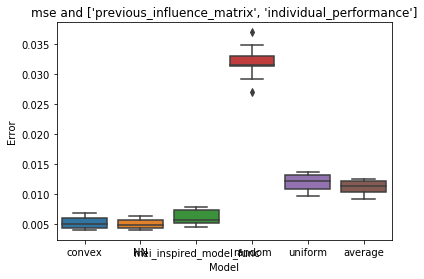

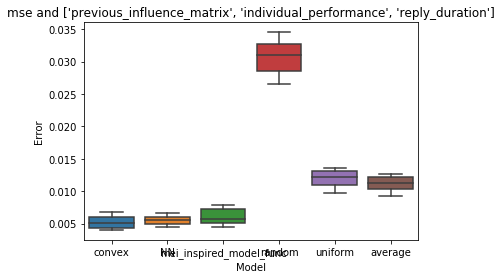

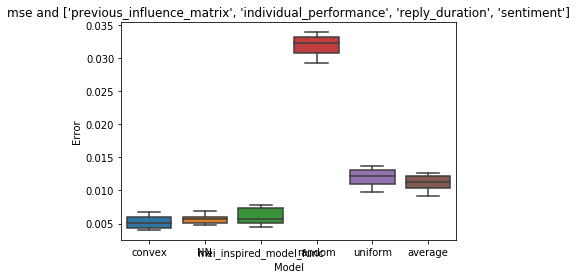

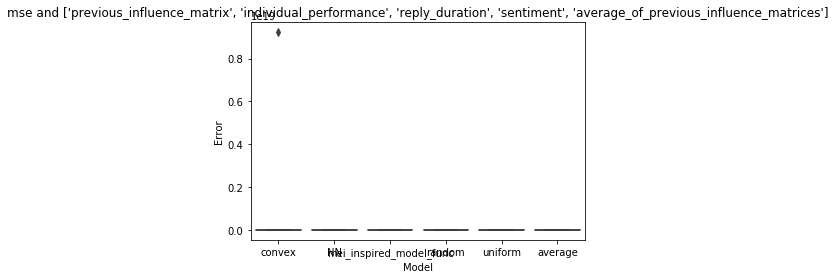

In [17]:
plot_all_result_from_errors_in_runs(test_errors_in_runs)

In [21]:
df = get_errors_in_table(test_errors_in_runs)

In [29]:
df

,Features,random,uniform,average,sbt_model_func,mei_inspired_model_func,convex_optimization_model_func,concatinated_deep_neural_network_model_func
0,"['previous_influence_matrix', 'individual_perf...",0.0320 $\pm$ 0.0026,0.0120 $\pm$ 0.0013,0.0112 $\pm$ 0.0011,,0.0061 $\pm$ 0.0012,0.0052 $\pm$ 0.0009,0.0050 $\pm$ 0.0008
1,"['previous_influence_matrix', 'individual_perf...",0.0308 $\pm$ 0.0026,0.0120 $\pm$ 0.0013,0.0112 $\pm$ 0.0011,,0.0061 $\pm$ 0.0012,0.0052 $\pm$ 0.0009,0.0056 $\pm$ 0.0007
2,"['previous_influence_matrix', 'individual_perf...",0.0320 $\pm$ 0.0015,0.0120 $\pm$ 0.0013,0.0112 $\pm$ 0.0011,,0.0061 $\pm$ 0.0012,0.0052 $\pm$ 0.0009,0.0057 $\pm$ 0.0006
3,"['previous_influence_matrix', 'individual_perf...",0.0329 $\pm$ 0.0019,0.0120 $\pm$ 0.0013,0.0112 $\pm$ 0.0011,,0.0061 $\pm$ 0.0012,922337203685477632.0000 $\pm$ 2767011611056433...,0.0055 $\pm$ 0.0007


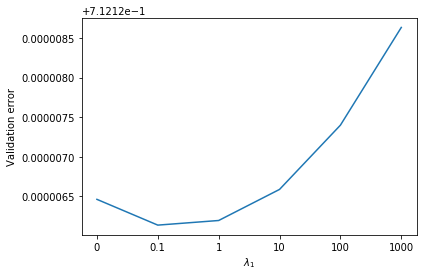

In [27]:
# train_errors_in_runs5 = utils.load_it('Outputs/train_errors5_Jan15.pkl.dill')
# test_errors_in_runs5 = utils.load_it('Outputs/test_errors5_Jan15.pkl.dill')
# validation_errors_in_runs5 = utils.load_it('Outputs/validation_errors5_Jan15.pkl.dill')

aa = []
for lambdaa in LAMBDAS:
    aa.append(validation_errors_in_runs5['l1']["['first_influence_matrix']"]['convex_optimization_model_func'][0][lambdaa])
f = plt.figure()
plt.plot(aa)
plt.xlabel('$\lambda_1$')
plt.ylabel('Validation error');
plt.xticks(range(len(LAMBDAS)), LAMBDAS)
f.savefig('regularization_parameter_tunning.png', bbox_inches='tight')
f.savefig('regularization_parameter_tunning.pdf', bbox_inches='tight')

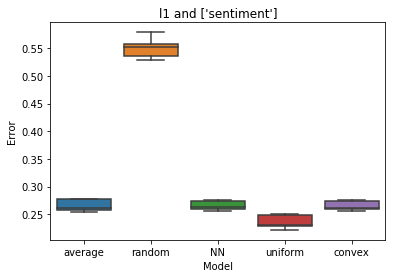

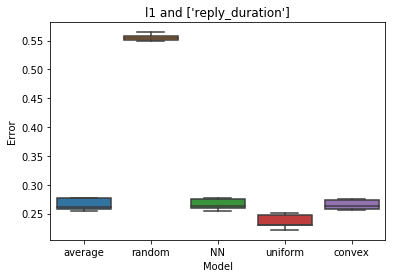

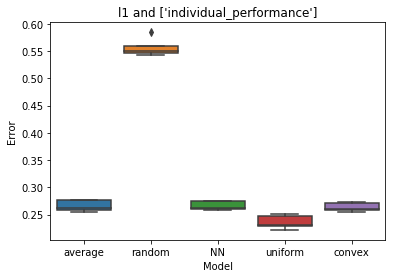

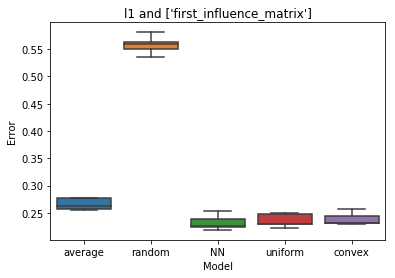

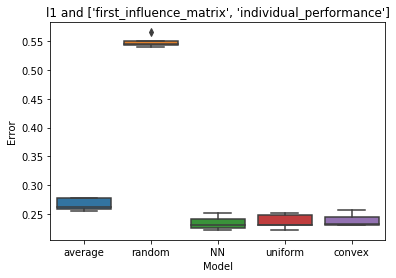

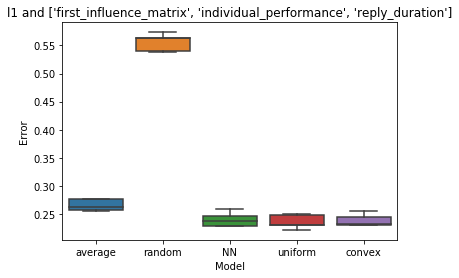

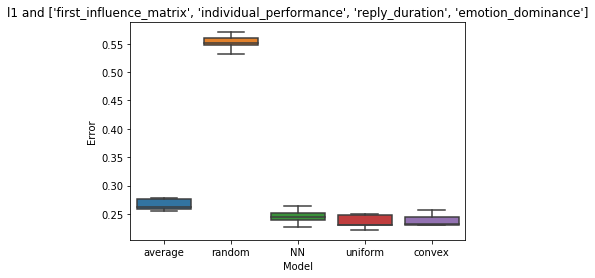

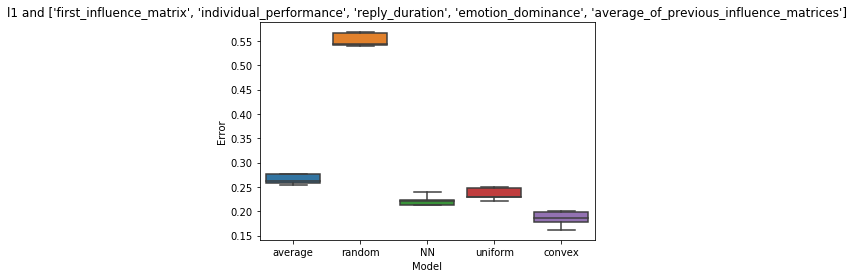

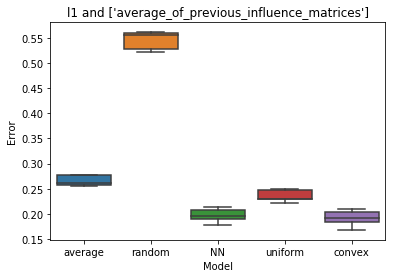

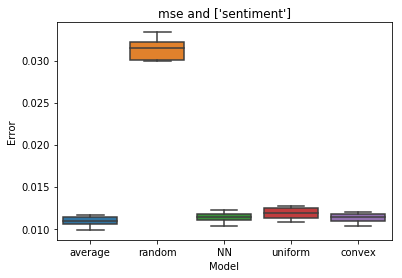

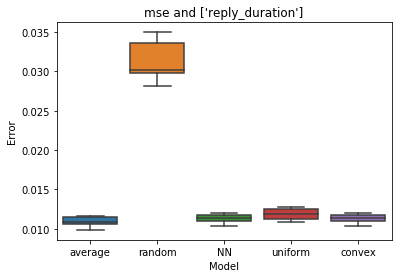

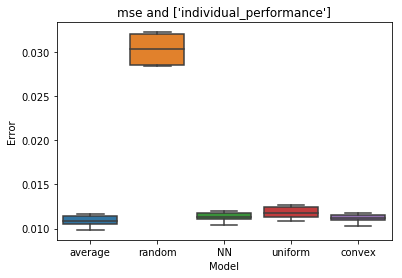

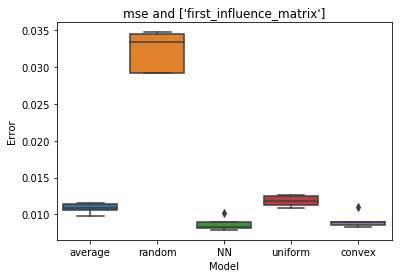

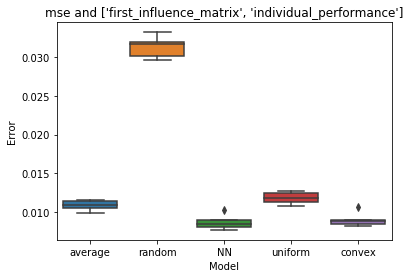

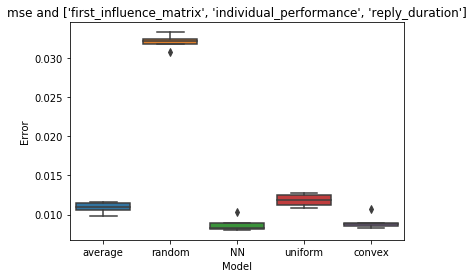

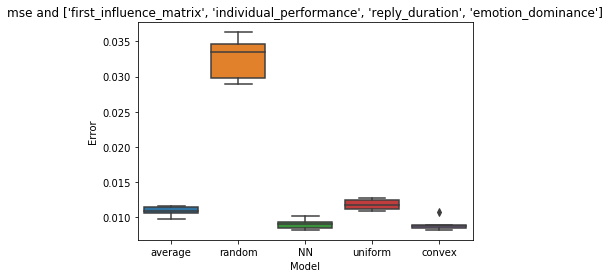

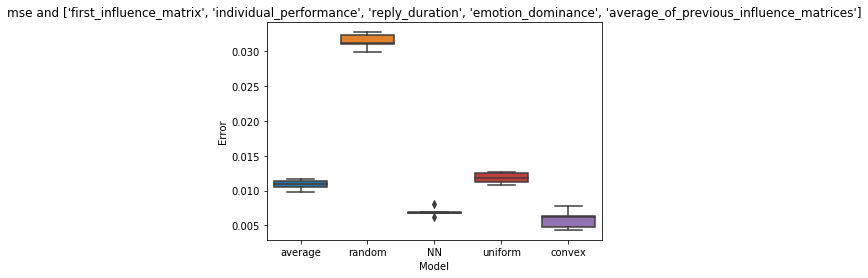

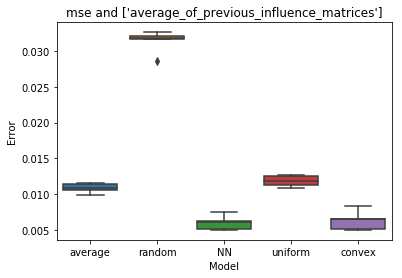

In [33]:
plot_all_result_from_errors_in_runs(test_errors_in_runs5)

In [70]:
list(test_errors_in_runs5['mse'].keys())

["['individual_performance']",
 "['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance']",
 "['sentiment']",
 "['average_of_previous_influence_matrices']",
 "['first_influence_matrix']",
 "['first_influence_matrix', 'individual_performance', 'reply_duration']",
 "['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance', 'average_of_previous_influence_matrices']",
 "['reply_duration']",
 "['first_influence_matrix', 'individual_performance']"]

In [71]:
df = get_errors_in_table(test_errors_in_runs5)

In [80]:
df

,Features,random,uniform,average,convex_optimization_model_func,concatinated_deep_neural_network_model_func
0,['sentiment'],0.0314 $\pm$ 0.0013,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0113 $\pm$ 0.0006,0.0113 $\pm$ 0.0006
1,['reply_duration'],0.0313 $\pm$ 0.0025,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0113 $\pm$ 0.0006,0.0113 $\pm$ 0.0006
2,['individual_performance'],0.0303 $\pm$ 0.0017,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0111 $\pm$ 0.0005,0.0113 $\pm$ 0.0006
3,['first_influence_matrix'],0.0322 $\pm$ 0.0025,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0092 $\pm$ 0.0009,0.0087 $\pm$ 0.0008
4,['average_of_previous_influence_matrices'],0.0314 $\pm$ 0.0014,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0063 $\pm$ 0.0012,0.0060 $\pm$ 0.0009
5,"['first_influence_matrix', 'individual_perform...",0.0313 $\pm$ 0.0013,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0090 $\pm$ 0.0009,0.0087 $\pm$ 0.0009
6,"['first_influence_matrix', 'individual_perform...",0.0322 $\pm$ 0.0008,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0090 $\pm$ 0.0009,0.0088 $\pm$ 0.0008
7,"['first_influence_matrix', 'individual_perform...",0.0326 $\pm$ 0.0028,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0090 $\pm$ 0.0009,0.0091 $\pm$ 0.0007
8,"['first_influence_matrix', 'individual_perform...",0.0314 $\pm$ 0.0010,0.0118 $\pm$ 0.0007,0.0109 $\pm$ 0.0006,0.0059 $\pm$ 0.0012,0.0069 $\pm$ 0.0006


In [81]:
df.iloc[3]

Features                                       ['first_influence_matrix']
random                                                0.0322 $\pm$ 0.0025
uniform                                               0.0118 $\pm$ 0.0007
average                                               0.0109 $\pm$ 0.0006
convex_optimization_model_func                        0.0092 $\pm$ 0.0009
concatinated_deep_neural_network_model_func           0.0087 $\pm$ 0.0008
Name: 3, dtype: object

### Different feature sets

In [77]:
LAMBDAS = [0, 0.1, 1, 10, 100, 1000]
WITH_REPLICATION = True
ERROR_TYPE_STRS = ['mse']
TUNE_HYPERPARAMETERS_BY_VALIDATION = True
RUNS = 6
SELECTED_MODEL_FUNCS = ['average', 'uniform', 'random', convex_optimization_model_func, concatinated_deep_neural_network_model_func]
FEATURE_NAMES_SET = [['first_influence_matrix'], ['first_influence_matrix', 'individual_performance'], ['first_influence_matrix', 'individual_performance', 'reply_duration'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance', 'average_of_previous_influence_matrices']]  # ['content_embedding_matrix'],
ESTIMATION_NAME = 'influence_matrix' #'most_influentials'

TO_WRITE_LOGS_ON_FILE = True

In [78]:
train_errors6 = utils.load_it('Outputs/train_errors6_multiple_features.pkl.dill')
test_errors6 = utils.load_it('Outputs/test_errors6_multiple_features.pkl.dill')

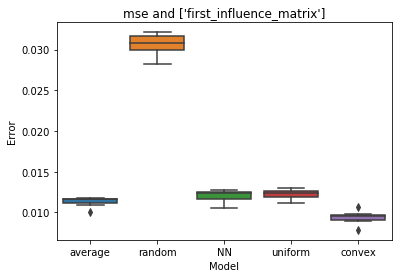

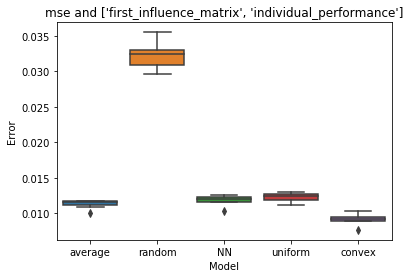

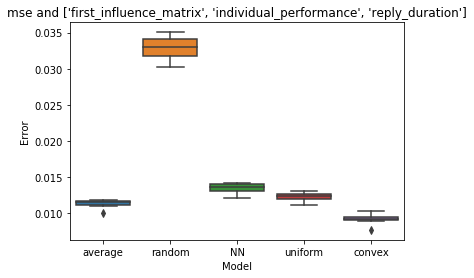

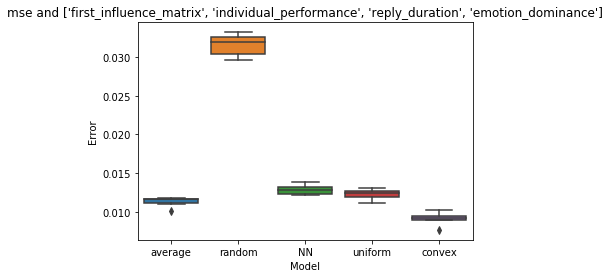

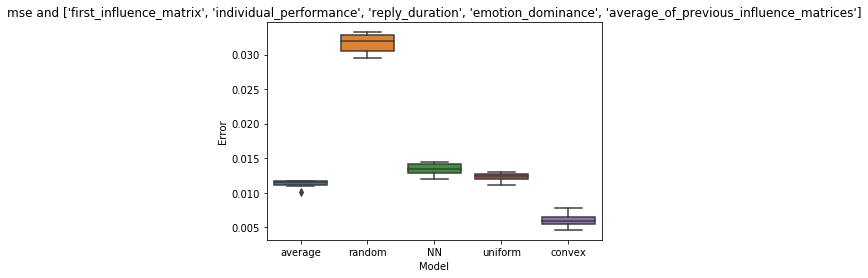

In [106]:
test_df = plot_all_result_from_errors_in_runs(test_errors6)

In [110]:
test_df[['random', 'uniform', 'average', 'NN', 'convex']]

,random,uniform,average,NN,convex
0,0.0306 $\pm$ 0.0014,0.0123 $\pm$ 0.0006,0.0113 $\pm$ 0.0006,0.0120 $\pm$ 0.0008,0.0094 $\pm$ 0.0008
1,0.0323 $\pm$ 0.0019,0.0123 $\pm$ 0.0006,0.0113 $\pm$ 0.0006,0.0118 $\pm$ 0.0008,0.0091 $\pm$ 0.0008
2,0.0328 $\pm$ 0.0017,0.0123 $\pm$ 0.0006,0.0113 $\pm$ 0.0006,0.0134 $\pm$ 0.0007,0.0092 $\pm$ 0.0008
3,0.0316 $\pm$ 0.0013,0.0123 $\pm$ 0.0006,0.0113 $\pm$ 0.0006,0.0129 $\pm$ 0.0006,0.0091 $\pm$ 0.0008
4,0.0316 $\pm$ 0.0014,0.0123 $\pm$ 0.0006,0.0113 $\pm$ 0.0006,0.0133 $\pm$ 0.0009,0.0061 $\pm$ 0.0010


average: 0.01068819221685517 +- 0.00015055087857948225
random: 0.031182776810748988 +- 0.0005147012750960701
NN: 0.01230027125225742 +- 0.00021926587702244047
uniform: 0.011535029920393338 +- 0.00015499104016939325
convex: 0.008427854896021115 +- 0.00016508381666789396


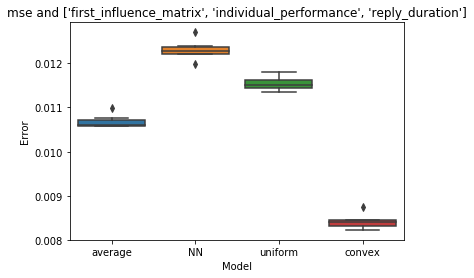



average: 0.01068819221685517 +- 0.00015055087857948225
random: 0.031580418190872546 +- 0.0007012412727360364
NN: 0.012142212213721934 +- 0.0002633033435233536
uniform: 0.011535029920393338 +- 0.00015499104016939325
convex: 0.0053757871245176 +- 0.0002902921178260132


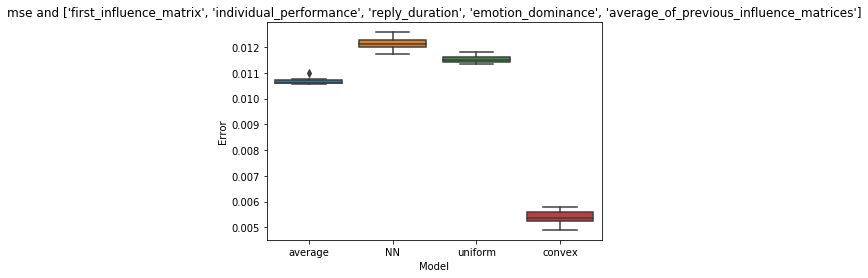



average: 0.01068819221685517 +- 0.00015055087857948225
random: 0.03084569241922157 +- 0.0007708533243434513
NN: 0.012107131612662579 +- 0.00020339442223157473
uniform: 0.011535029920393338 +- 0.00015499104016939325
convex: 0.00838107046043757 +- 0.00018196342357082782


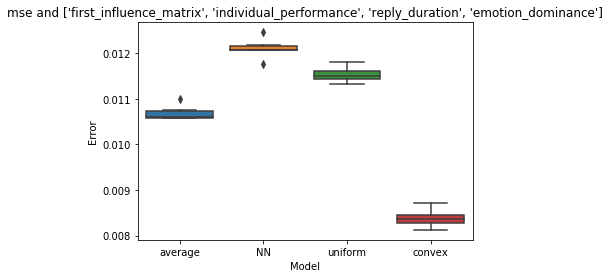



average: 0.01068819221685517 +- 0.00015055087857948225
random: 0.03135703847072138 +- 0.00027733331040521997
NN: 0.011041913768771693 +- 0.00019781322920530396
uniform: 0.011535029920393338 +- 0.00015499104016939325
convex: 0.008482931986286453 +- 0.00018460824469272052


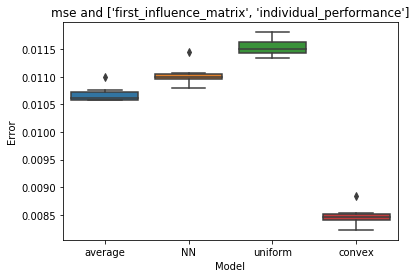



average: 0.01068819221685517 +- 0.00015055087857948225
random: 0.03085255565012883 +- 0.0009029441312250193
NN: 0.011225154051228418 +- 0.0002215513214452571
uniform: 0.011535029920393338 +- 0.00015499104016939325
convex: 0.008852357832785405 +- 0.00020527803180932463


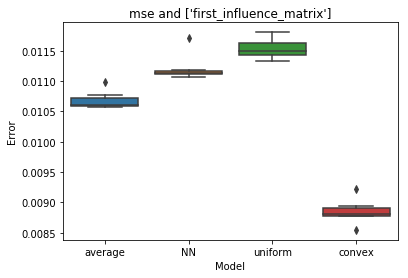

In [89]:
plot_all_result_from_errors_in_runs(train_errors6)

In [6]:
test_errs = []

X_trains = []
X_tests = []
y_trains = []
y_tests = []

with Timer():
    for run in range(RUNS):
        print('RUN {} =>>>>'.format(run))
        X_train, X_test, y_train, y_test = train_test_split(
            np.array(data['X']), np.array(data['y']), test_size=TEST_FRACTION)

        _, tes, _ = model_builder(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            feature_names=['previous_influence_matrix', 'individual_performance'],
            estimation_name=ESTIMATION_NAME,
            error_type_str='mse',
            tune_hyperparameters_by_validation=True,
            with_replication=False,
            lambdas=LAMBDAS,
            model_func=convex_optimization_model_func,
            params={'with_constraints': True, 'n_splits': 3, 'n_epochs': 10, 'batch_size': 32})
        test_errs.append(tes)
        X_trains.append(X_train)
        X_tests.append(X_test)
        y_trains.append(y_train)
        y_tests.append(y_test)

RUN 0 =>>>>
3-fold validation ...
Shapes of train: (140,), validation: (71,), test: (53,).
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 10.943989581605312
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 11.404120673929562
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 15.252298349812376
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 51.25924073556216
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 411.2592261766873
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 4011.259022630131
Shapes of train: (141,), validation: (70,), test: (53,).
Computing convex loss on 141 training data samples.
The status of solution was: optimal and t

The status of solution was: optimal and the result was: 13.064995748218752
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 16.856343738132804
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 52.85818002582518
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 412.85818224711284
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 4012.857988657975
Shapes of train: (141,), validation: (70,), test: (53,).
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 12.956703976079726
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 13.40842331607517
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 1

The status of solution was: optimal and the result was: 51.67278212315783
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 411.6727650798148
Computing convex loss on 140 training data samples.
The status of solution was: optimal and the result was: 4011.672752332763
Shapes of train: (141,), validation: (70,), test: (53,).
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 10.572202403370905
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 11.014930506401512
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 14.791163542229162
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 50.79999334042851
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 41

The status of solution was: optimal and the result was: 4011.820443395958
Shapes of train: (141,), validation: (70,), test: (53,).
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 10.462354858468116
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 10.903586968375171
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 14.643382853006491
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 50.646388386903794
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 410.64637429530603
Computing convex loss on 141 training data samples.
The status of solution was: optimal and the result was: 4010.646343113799
Shapes of train: (141,), validation: (70,), test: (53,).
Computing convex loss on 141 training data samples.

In [8]:
print(np.mean(test_errs), '+-', np.std(test_errs))

0.004865831602627442 +- 0.001176386550418567


In [44]:
import glob

average_val_in_matrix = defaultdict(list)
for filename in glob.glob('cvxvars_2020-01-23*'):
    estimated_params = utils.load_it(filename)
    for k, v in estimated_params['Ws'].items():
        average_val_in_matrix[k].append(np.mean(abs(v.value)))

In [45]:
feat_names = ['reply_duration',
 'emotion_valence',
 'sentiment',
 'content_embedding_matrix',
 'individual_performance',
 'previous_influence_matrix']

for feat_name in feat_names:
    v = average_val_in_matrix[feat_name]
    print('{}:  {} +- {}'.format(feat_name, np.mean(v), np.std(v)))

reply_duration:  0.00411496728075526 +- 0.0003503350589011823
emotion_valence:  0.005010795958215642 +- 0.00071304366562726
sentiment:  0.007847818195191253 +- 0.0010506750059684313
content_embedding_matrix:  0.011142281790357712 +- 0.00031790712692542143
individual_performance:  0.023876686975759023 +- 0.002694384967692191
previous_influence_matrix:  0.21373836450946518 +- 0.002698470829594352


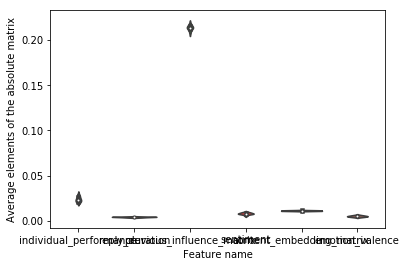

In [53]:
dt = []
for k, vs in average_val_in_matrix.items():
    for v in vs:
        dt.append([k, v])
df = pd.DataFrame(dt, columns=['Feature name', 'Average elements of the absolute matrix'])
ax = sns.violinplot(x="Feature name", y="Average elements of the absolute matrix", data=df)

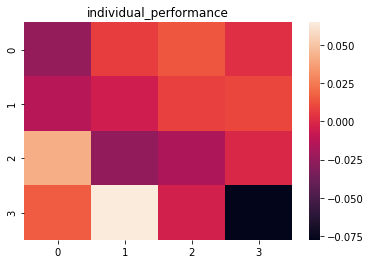

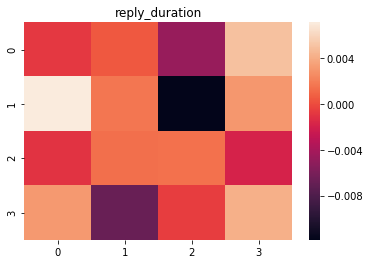

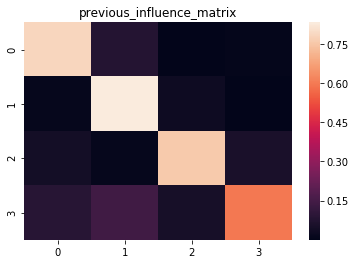

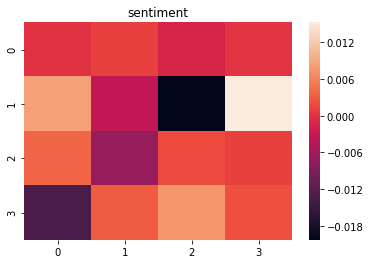

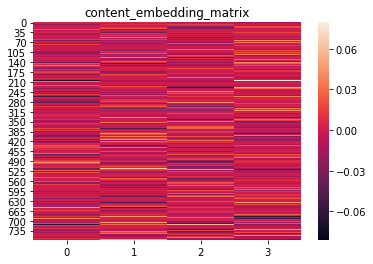

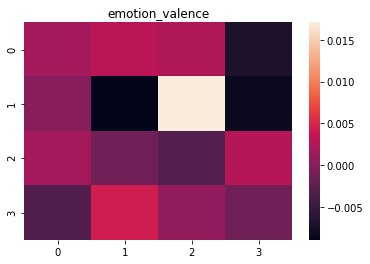

In [56]:
for k, v in estimated_params['Ws'].items():
    sns.heatmap(v.value)
    plt.title(k)
    plt.show()
    print('\n')

Text(0.5,1,'Bias')

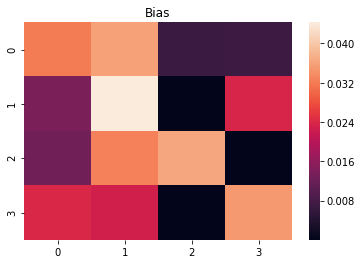

In [58]:
sns.heatmap(estimated_params['B'].value)
plt.title('Bias')

# Just for debugging.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(data['X']), np.array(data['y']), test_size=TEST_FRACTION)

with Timer():
    tra, tes, val = model_builder(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
#         feature_names=['individual_performance', 'previous_influence_matrix', 'average_of_previous_influence_matrices', 'emotion_dominance', 'emotion_valence', 'sentiment', 'first_influence_matrix', 'emotion_arousal', 'content_embedding_matrix', 'reply_duration', 'individual_performance_hardness_weighted'],
        feature_names=['previous_influence_matrix', 'individual_performance'],
        estimation_name=ESTIMATION_NAME,
        error_type_str='mse',
        tune_hyperparameters_by_validation=False,
        with_replication=True,
        lambdas=LAMBDAS,
        model_func=sbt_model_func,
        params={'with_constraints': False, 'n_splits': 3, 'n_epochs': 10, 'batch_size': 32, 'mode': 1})

In [49]:
tra

0.0015644795601423424

In [37]:
tes

0.01922002545912305

In [51]:
val

defaultdict(<function estimation_lib.model_builder.<locals>.<lambda>>, {})

In [28]:
estimated_params1 = utils.load_it('cvxvars.pkl')

In [53]:
abss = []
names = []
for k, v in estimated_params['Ws'].items():
    names.append(k)
    abss.append(np.mean(abs(v.value)))

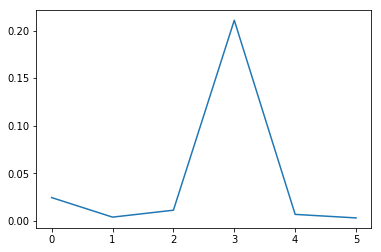

In [54]:
plt.plot(abss);

In [55]:
[name for _,name in sorted(zip(abss, names))]

['reply_duration',
 'emotion_valence',
 'sentiment',
 'content_embedding_matrix',
 'individual_performance',
 'previous_influence_matrix']

In [56]:
sorted(abss)

[0.0029204103708461147,
 0.0037488990491842404,
 0.006643426162339542,
 0.011028171884645438,
 0.024316207540909213,
 0.2108975956253037]

In [60]:
estimated_params1['B'].value

matrix([[3.40113922e-02, 2.25037801e-02, 1.06224056e-02, 1.89164049e-02],
        [2.65567173e-02, 4.13158005e-02, 3.67006863e-03, 1.45114129e-02],
        [2.48785347e-02, 2.83463747e-02, 3.28264803e-02, 2.57996993e-06],
        [3.58180138e-02, 2.08943373e-02, 1.00359549e-02, 1.93056457e-02]])

individual_performance
[[-1.86175983e-02 -1.87591247e-02  3.73783143e-02 -1.43038691e-06]
 [-1.21487871e-02  1.08549834e-06  1.21367871e-02  1.09825380e-05]
 [ 6.11183774e-02 -3.64073116e-02 -1.52127213e-02 -9.49840201e-03]
 [ 5.14015170e-04  8.33700972e-02 -1.01857159e-02 -7.36985699e-02]]


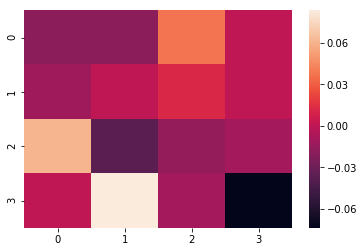



previous_influence_matrix
[[7.03304278e-01 5.77342058e-02 9.40080198e-04 8.16119011e-02]
 [1.48347702e-02 7.86754360e-01 4.19972140e-02 4.03339086e-06]
 [1.27721480e-02 8.60410780e-03 7.64839129e-01 5.73750276e-02]
 [5.74071607e-02 1.19055877e-01 5.49177010e-02 6.12209535e-01]]


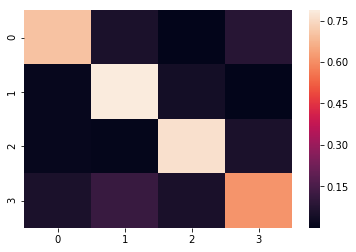



emotion_valence
[[ 0.0013719  -0.00065839  0.00499063 -0.00570414]
 [ 0.00255286 -0.00670906  0.00795636 -0.00380027]
 [ 0.0023941   0.00259816 -0.00437773 -0.00061459]
 [-0.00594917  0.00643614  0.00169096 -0.00217792]]


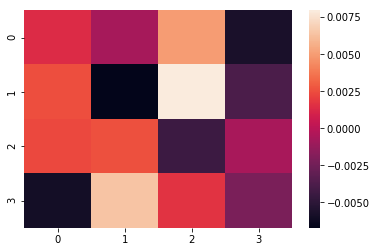



content_embedding_matrix
[[-7.79705141e-07 -1.59876191e-02  2.40586646e-06  1.11104141e-02]
 [-2.44177251e-02  3.20320404e-07  2.57095712e-02 -6.22422739e-03]
 [-1.47883654e-04  2.65989093e-06 -1.44602770e-07 -4.45489291e-03]
 ...
 [ 1.62558632e-02 -4.27861596e-02  1.83595369e-02  3.33740940e-03]
 [ 1.61602821e-02 -1.41336768e-05  1.66049623e-03 -2.27317135e-02]
 [ 2.45491860e-03  3.04580253e-02 -4.36677502e-06 -3.77816852e-02]]


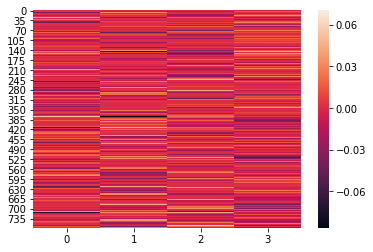



reply_duration
[[-8.32219853e-05  1.35352380e-03 -6.13178327e-03  4.86150830e-03]
 [ 4.83929194e-03 -6.87781238e-04 -2.79645223e-03 -1.35502049e-03]
 [ 2.45524219e-03  6.69259021e-07 -1.05282449e-06 -2.45489271e-03]
 [ 4.86556302e-03 -8.04030108e-03 -1.81280175e-03  4.98745985e-03]]


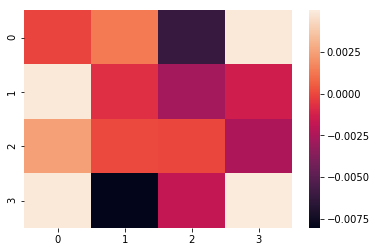



sentiment
[[-0.00367134  0.00311477 -0.00083323  0.0013897 ]
 [-0.00365773  0.00093251 -0.01794617  0.02067147]
 [ 0.00033393 -0.0117284   0.00652554  0.00486902]
 [-0.01483236  0.01260083  0.00270974 -0.00047808]]


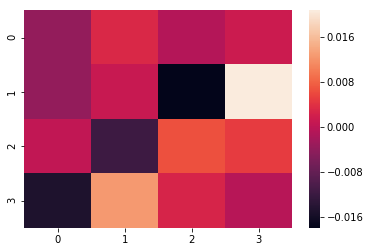

In [31]:
for k, v in estimated_params1['Ws'].items():
    print(k)
    print(v.value)
    sns.heatmap(v.value)
    plt.show()
    print('\n')